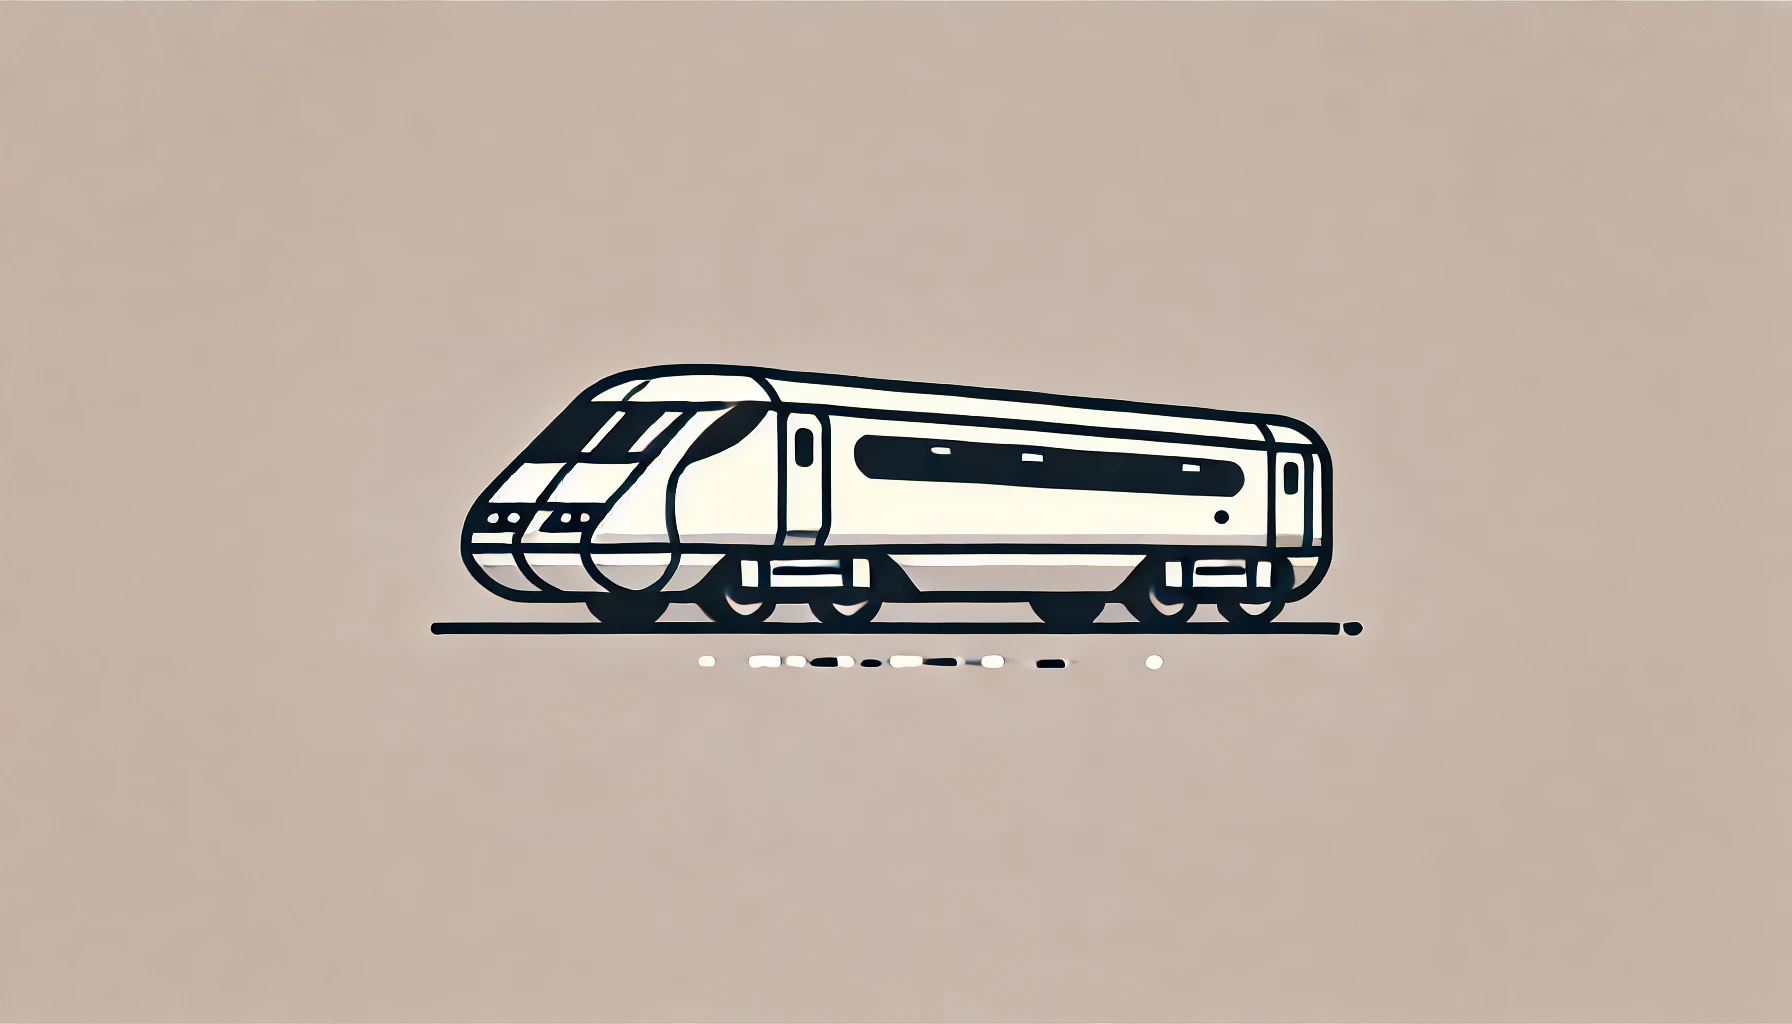


## YOLO for Trains

[COLAB](https://drive.google.com/file/d/1OvHkQ7X469aDUmnCtVEUsw1fTCRQyN9M/view?usp=sharing)

In this assignment we have a raw dataset of images of train tracks. Using some labeling software like label-studio or roboflow we can turn this into a proper yolo dataset - in this case I went for label-studio. Once our dataset is created, since we have a pretty vague problem or description I went for using a more straight-forward solution. I went to ultralytics.com and uploaded my dataset, which I then used to train the SOTA YOLO11n model. The code for this training can be found lower.

In [90]:
%pip install ultralytics gradio -q  # install
%pip install gdown gitpython setuptools==70.0.0 torchviz -q

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [91]:
from ultralytics import YOLO, checks, hub
import gradio as gr
import torch
import gdown
import cv2
import numpy as np
from PIL import Image
import os
checks()  # checks

Ultralytics 8.3.86 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 4080 Laptop GPU, 11885MiB)
Setup complete ✅ (24 CPUs, 31.0 GB RAM, 874.5/1635.4 GB disk)


In [92]:
#model = YOLO('yolov8n.pt')
# we could just try a raw prue code appraoc

### About our Model
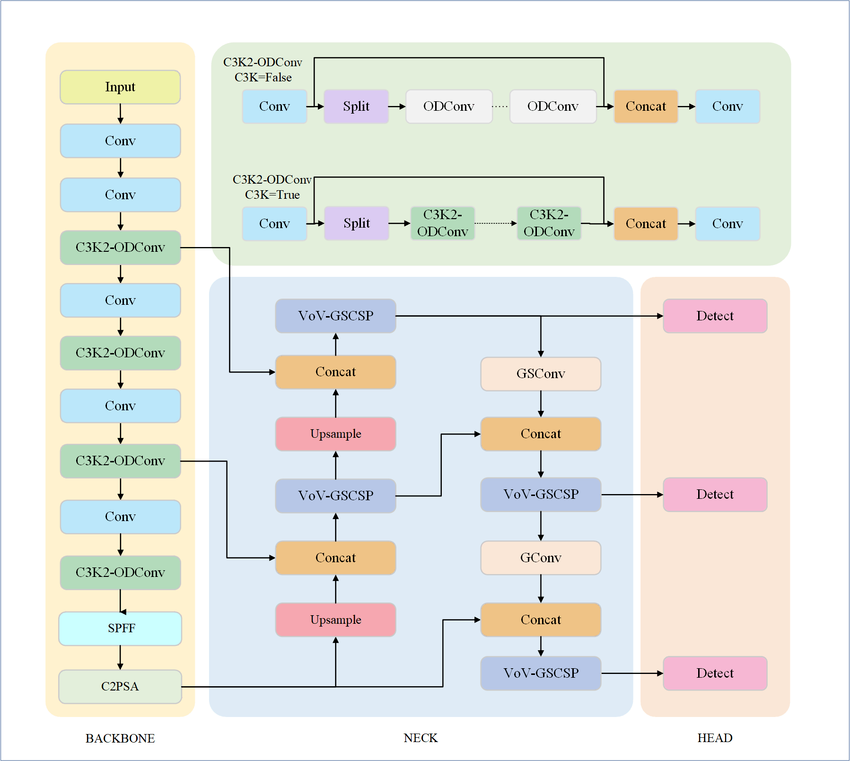

YOLO11n is the lightweight "Nano" variant within the new YOLO11 family developed by Ultralytics. It’s engineered for speed and efficiency, making it ideal for real-time applications and deployment on edge devices with limited computational resources (such as perhaps on a rail-road). With a streamlined design featuring advanced feature extraction in its backbone and an optimized neck, YOLO11n achieves competitive detection accuracy while using fewer parameters (around 2.6 million).

Our model will take in a 1024 (long-side), we train it for 80 epochs (around 100 it starts to overfit as observed on prior tests).

In [93]:
"""
hub.login('REDACTED')
model = YOLO('https://hub.ultralytics.com/models/CN9VEPuv46lrpHAd06CC')
results = model.train()
"""
pass

#### TRAINING LOGS
Logs can be found [HERE](https://gist.github.com/velocitatem/70f6531f517a4889c477d0338603821b) since the non-unicode characters cannot be pasterd into the notebook...


### Results
| Metric | View |
|-|-|
| Metrics | 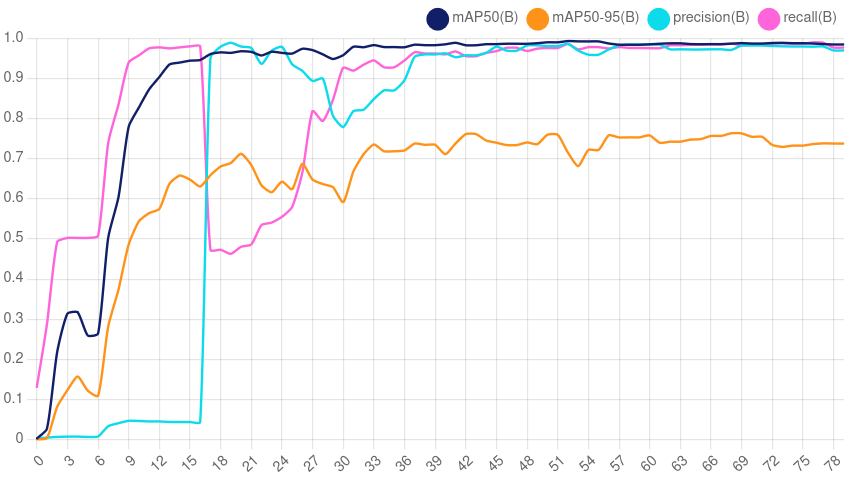 |
| Box Diff Loss | 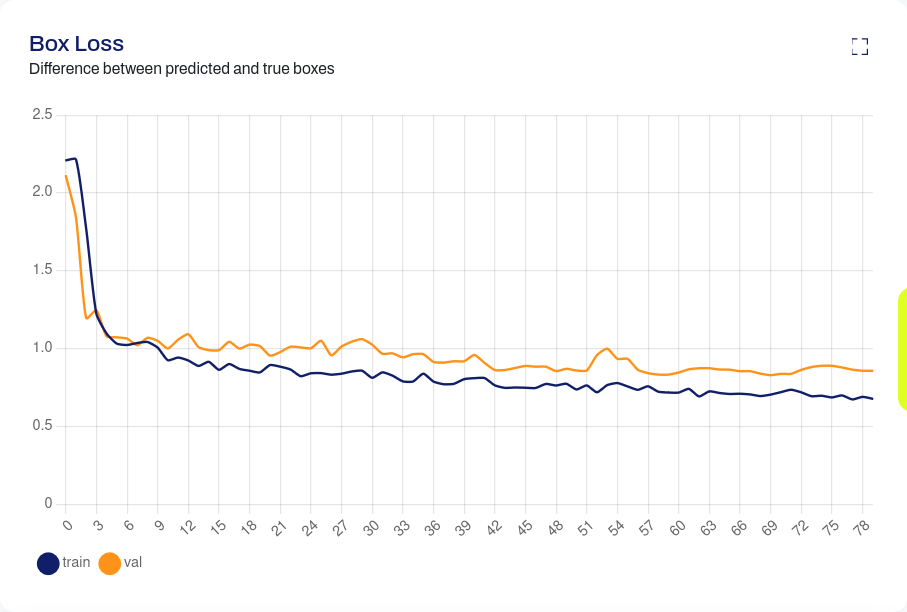 |
| Class Detection Loss | 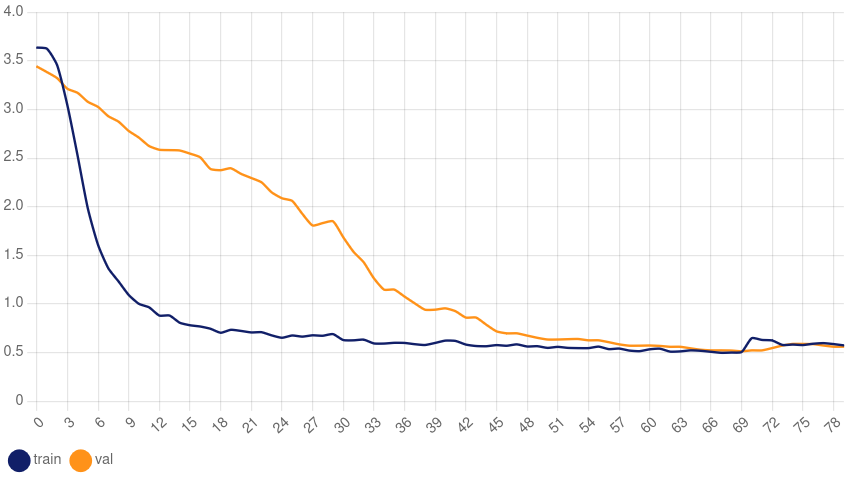 |


In the first metrics plot we are talking about mAP50, mAP50-95. The first is a measure of the mean average precision of intersection with a threshold 0.5 and the second is the same but adjusts the threshold to a range of (0.5 0.95). For this training we see map50 level of right under 1 and the same goes for precision and recall. Seeing out loss, we could possibly stop our model training ealier but since our dataset is not ideal and our test sample is a bit small I still decided to let it run a bit longer, possibly around 50 epoch could be ideal for a more robust future model. In the last plot we see that around 80 epoch however, both our train and validation losses converge.

## Inferece

To see how our model is doing I think it would be nice to build a gradio interface which can run our model on any images we give it. I uploaded the final model checkpoint to huggingface so that we can eassily access it anywhere.

In [94]:
!wget https://huggingface.co/velocitatem/railway-image-processing/resolve/main/model_-%208%20march%202025%2023_19.pt

--2025-03-09 18:48:46--  https://huggingface.co/velocitatem/railway-image-processing/resolve/main/model_-%208%20march%202025%2023_19.pt
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
18.155.129.4, 18.155.129.129, 18.155.129.31, ...
Connecting to huggingface.co (huggingface.co)|18.155.129.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.hf.co/repos/a0/23/a0232ca49bb707710b8c961395f1efbc121eb84722d89d8f8c4269c7768d9e2b/e378627b7a5dcc37e1ca003b03ed5a3a4ea20713f2a712afb8645f3ba7e44283?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27model_-%2525208%252520march%2525202025%25252023_19.pt%3B+filename%3D%22model_-%25208%2520march%25202025%252023_19.pt%22%3B&Expires=1741546126&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc0MTU0NjEyNn19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmhmLmNvL3JlcG9zL2EwLzIzL2EwMjMyY2E0OWJiNzA3NzEwYjhjOTYxMzk1ZjFlZmJjMTIxZWI4NDcyMmQ4OWQ4ZjhjNDI2OW

In [95]:

def predict(image): # this is our main inference method
    if len(image.shape) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB) # although not necessary
        # since our images come in grayscale but still could be helpful as preprocessing of any defects or anything.
    elif image.shape[2] == 4:
        image = cv2.cvtColor(image, cv2.COLOR_RGBA2RGB)
    
    model = YOLO("model_- 8 march 2025 23_19.pt")
    
    results = model(image) # rn it.
    print(results)
    
    # Use the 'plot' method to get the annotated image
    if results:
        annotated_img = results[0].plot()
    else:
        raise ValueError("No results were returned by the model.")
    
    # Convert to PIL Image
    rendered_img = Image.fromarray(annotated_img)
    
    return rendered_img


In [96]:
model=YOLO("model_- 8 march 2025 23_19.pt") # we load up our wegits

In [97]:
model.info()

YOLO11n summary: 181 layers, 2,590,230 parameters, 0 gradients, 6.4 GFLOPs


(181, 2590230, 0, 6.4416768)

As mentioned at the start we have a roughly 2mil parameter model, which is pretty big but it gets the job done very well

In [98]:
def create_interface():
    interface = gr.Interface(
        fn=predict,
        inputs=gr.Image(type="numpy"),
        outputs=gr.Image(type="pil"),
        title="YOLO Railroad AI",
        description="Upload an image to detect sleepers and clips using YOLO model",
    )
    return interface

In [99]:
interface = create_interface()
interface.launch(share=True) # UNCOMMENT TO RUN THE INTERFACE

* Running on local URL:  http://127.0.0.1:7869
* Running on public URL: https://3ac10aaabdb1167730.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


From our test subset I tried various images and here is an example of one of them post inference, when our model gives us bounding boxes for each correct clip and sleeper.

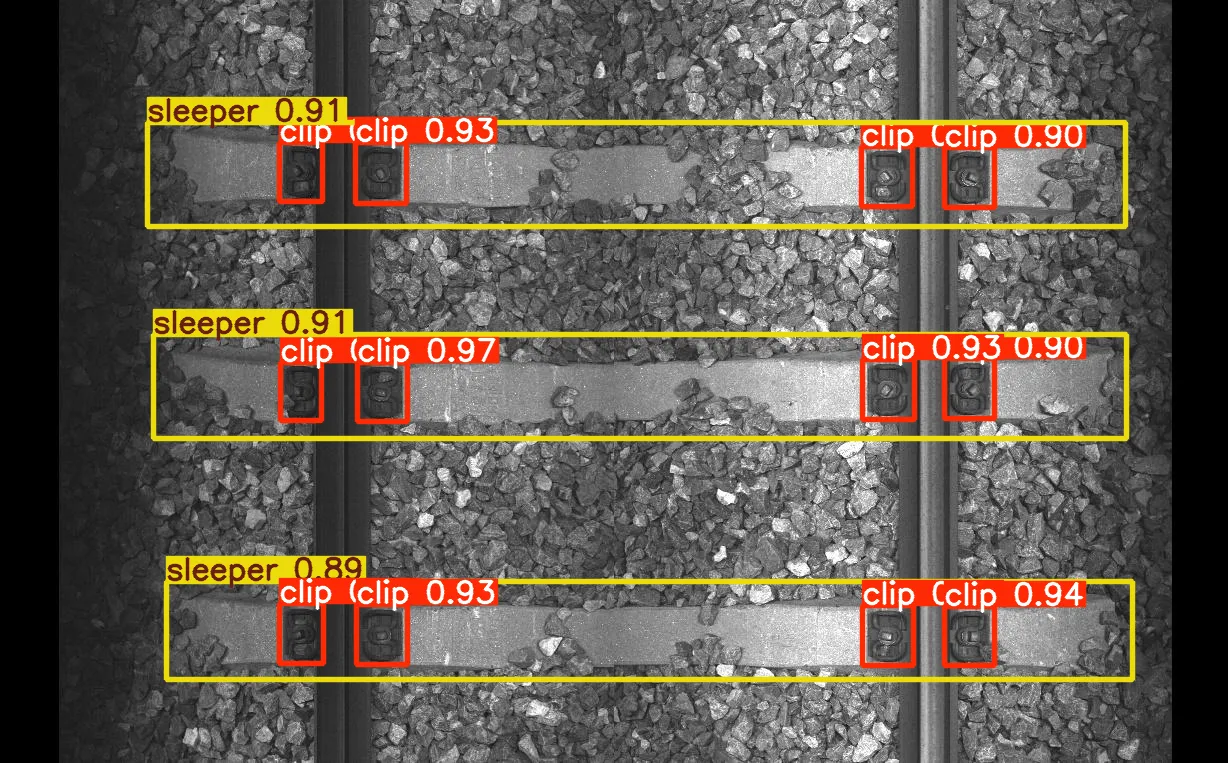